In [ ]:
from sympy import *
from sympy.utilities.lambdify import lambdify
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Motter 2009 finds that if V4 receptive fields are plotted in the coordinates of V1 (roughly a log polar transform of visual space) then receptive fields are well described by a guassian surface with constant width (SD) with respect to eccentricity. If receptive fields are fit in visual space coordinates then the SD changes with eccentricity and the guassian surface fit is not good because the receptive fields are skewed away from the fovea. 

This suggests it is better to find RF profiles in the coordinates of V1 as the only parameter to estimate would be the center of the receptive field and thus our estimates would be more accurate. Even if we do estimate the size of the receptive field we would expect there to be less correlation between estimates of SD and receptive field position. 

Motter models V1 as a 3-d surface (football shaped) onto which visual space a 2-d surface is mappped.

The equations which Motter uses to perform this mapping from visual space to V1 takes:

$$v(\theta, w)\rightarrow c(r,z,\phi)$$

where $\theta$ is azimuth and $w$ eccentricity in visual space. $r$ is the radius of the football, $z$ is the distance measured through the football, and $\phi$ the angle looking head on at the point of the football.

The transform is as follows:

$$r= M(w) sin(w)$$

$$z=\int_0^w [M(w)^2-(\frac{dr}{dw})^2]^{0.5} dw$$

$$\phi=\theta$$

The function $M(w) \ (\frac{mm}{\text{deg}})$ is the cortical magnification factor which is the number of millimeters on cortex corresponding to a degree visual angle as a function of eccentricity.

The authors use the CMF for macaques takes from Levay et. al. (1985) in the paper written as:
$M(w)_a = 100(0.8 + w)^{-2}$ but this is for magnification in square mm per square degree visual angle so for the formula above we take the square root.
$$M(w) = 10(0.8 + w)^{-1}$$

From the formula we see $r$ and $z$ are purely a function of eccentricity $w$ and theta is a direct mapping.

([], <a list of 0 Text yticklabel objects>)

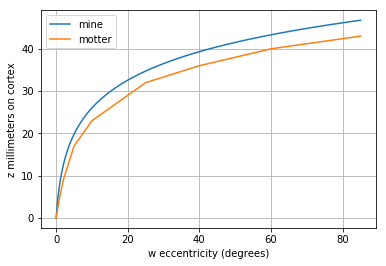

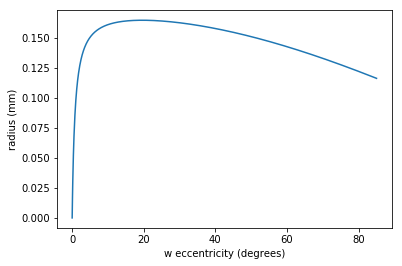

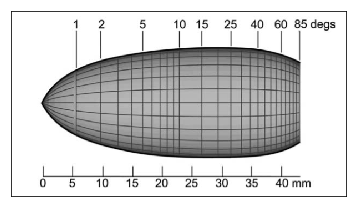

In [184]:
w = np.linspace(0,85,1000)
dw = w[1]-w[0]

a = 103 
b = 0.82 
x = 2.28

a = 100 
b = 0.8
x = 2

mw = np.sqrt(a/(b+w)**x)#had to change this to nine to get it to fit.

r = mw*np.sin(np.deg2rad(w))

drdw = np.gradient(r,dw)

z = sc.integrate.cumtrapz((mw**2.-drdw**2.)**0.5, 
                          dx=dw, initial=0)

plt.plot(w,z);
plt.xlabel('w eccentricity (degrees)');
plt.ylabel('z millimeters on cortex');
plt.grid();


wm = [0, 1,2,5,10,15,25,40,60,85]
zm = [0, 5, 9, 17, 23, 26,32, 36,40, 43]
plt.plot(wm,zm);
plt.legend(['mine', 'motter']);
plt.figure()
plt.plot(w, r);
plt.xlabel('w eccentricity (degrees)');
plt.ylabel('radius (mm)')
plt.figure()
plt.imshow(plt.imread('/Users/deanpospisil/Desktop/mot.png'));plt.xticks([]);plt.yticks([])


I am not sure why but mine seems to overshoot Motter's. I am going to move forward and build the fitting procedure around this mapping and the mapping can be fixed later.

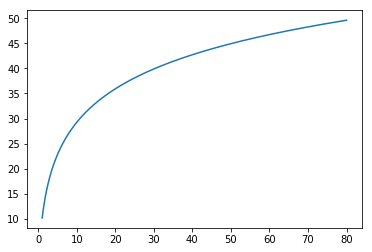

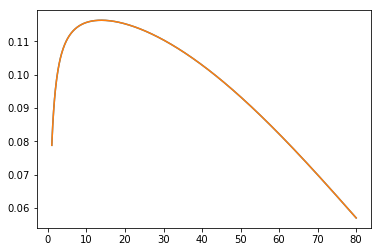

In [235]:
def v_to_c(x,y):
    winit = (x**2. + y**2.)**0.5
    
    w = np.linspace(0,winit,1000)
    dw = w[1]-w[0]
    mw = np.sqrt(100/(.8+w)**2)#had to change this to nine to get it to fit.

    r = mw*np.sin(np.deg2rad(w))

    drdw = np.gradient(r,dw)
 
    z = sc.integrate.trapz((mw**2.-drdw**2.)**0.5, 
                              dx=dw)
    
    phi = np.arctan(y/x)
    x, y = np.array([np.cos(phi), np.sin(phi)])*r[-1]
    return x, y, z


y = np.linspace(1,80,1000);
x = y
xyz = np.array([v_to_c(ay,ay) for ax,ay in zip(x,y)]).squeeze()
plt.plot(y, xyz[:,-1])
plt.figure()
plt.plot(y, xyz[:,1])
plt.plot(y, xyz[:,0]);


In [225]:
xyz.shape

(100, 3)

[(0.00020341812118910939,
  0.00020341812118910936,
  array([ 0.        ,  0.00168427,  0.00321338,  0.00461358,  0.00590493,
          0.00710315,  0.0082208 ,  0.00926803,  0.01025319,  0.01118324,
          0.01206402,  0.01290049,  0.0136969 ,  0.01445691,  0.01518371,
          0.01588007,  0.01654844,  0.017191  ,  0.01780965,  0.01840612,
          0.01898194,  0.01953849,  0.02007702,  0.02059867,  0.02110445,
          0.02159531,  0.0220721 ,  0.0225356 ,  0.02298654,  0.02342558,
          0.02385332,  0.02427035,  0.02467718,  0.02507429,  0.02546215,
          0.02584117,  0.02621174,  0.02657424,  0.02692902,  0.02727638,
          0.02761664,  0.02795008,  0.02827696,  0.02859755,  0.02891208,
          0.02922077,  0.02952384,  0.02982148,  0.0301139 ,  0.03040126,
          0.03068374,  0.03096151,  0.03123471,  0.03150351,  0.03176802,
          0.0320284 ,  0.03228477,  0.03253724,  0.03278594,  0.03303098,
          0.03327246,  0.03351049,  0.03374516,  0.03397656,